# Capstone: Classifying Artefacts in the National Collection

## Overview

Background
- Cataloguing artefacts involves systematically documenting information about cultural, historical, or scientific objects. It includes creating a comprehensive inventory, organizing objects, and providing detailed descriptions and metadata. Proper cataloguing enables efficient management, preservation, and access to collections, supporting research and promoting access to cultural heritage.

- The cataloguing process can involve both manual and automated elements, depending on the institution and the scale of the collection. Traditionally, cataloguing was primarily a manual process that involved physically documenting information about each artefact on paper records or index cards. However, with the advancement of technology, many institutions now utilize specialized cataloguing databases to create and manage digital records for their collections.

In this project, we will develop an image classification model predicting selected labels for the metadata of an artefact that the cataloguer would have to tag.
- `Multi-class Image Classification`: Predicting labels for five (5) classes of images/artefacts according to their categories.
- `Multi-label Image Classification`: Predicting a set of labels corresponding to the object and attribute present in an image. 

## Problem Statement

To develop an image classification system that accurately predicts tags for artefacts captured in the photographs, for more efficient cataloguing of Singapore’s national treasures. Success will be measured by the accuracy of the model in classifying the artefact.  


## Success Metric
Accuracy is a commonly used metric for evaluating the performance of an image classification system, measuring the proportion of correctly classified images compared to the total number of images. 

Accuracy will be used as the success metric for this project as it is easy to interpret and the target class is well balanced. A wrong classification of the image would have limited impact as the complete cataloguing process would involve detailed verification checks (e.g. via research on the objects..).


In [ ]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load and preprocess images


In [ ]:
PATH = '/content/drive/MyDrive/Capstone/multi-class/images_multiclass'

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 4292 files belonging to 5 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1501 files belonging to 5 classes.


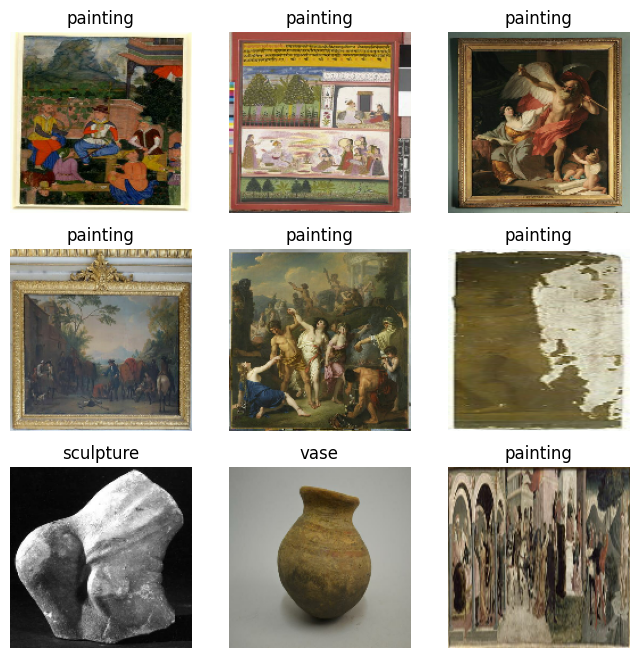

In [ ]:
#Show the first nine images and labels from the training set:
class_names = train_dataset.class_names

plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Create test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)  #Take one-fifth of the validation dataset & assign to test_dataset
validation_dataset = validation_dataset.skip(val_batches // 5)  #Excludes images taken for validation dataset

Examining the number of batches, helpful when setting the steps_per_epoch and validation_steps parameters in the fit() method

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 38
Number of test batches: 9


Configure the dataset for performance

In [ ]:
#prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

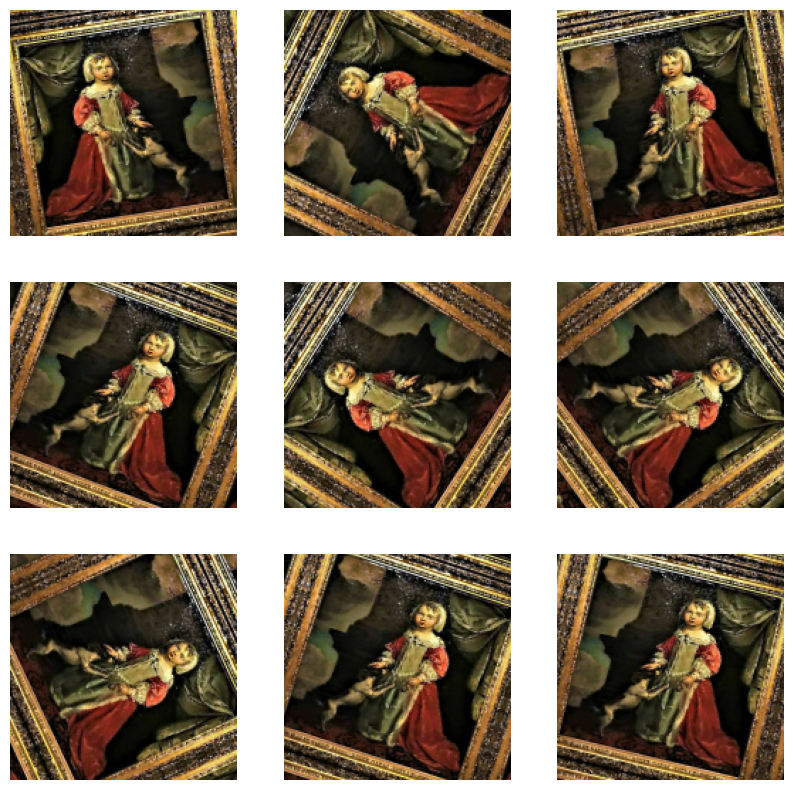

In [ ]:
# Repeatedly apply these layers to the same image & see results
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
num_classes = 5

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(160, 160, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
135/135 [==============================] - 531s 4s/step - loss: 1.1878 - accuracy: 0.5226 - val_loss: 1.7511 - val_accuracy: 0.3677
Epoch 2/10
135/135 [==============================] - 17s 121ms/step - loss: 0.9262 - accuracy: 0.6368 - val_loss: 1.4387 - val_accuracy: 0.5045
Epoch 3/10
135/135 [==============================] - 19s 135ms/step - loss: 0.7786 - accuracy: 0.7018 - val_loss: 1.6727 - val_accuracy: 0.4790
Epoch 4/10
135/135 [==============================] - 17s 122ms/step - loss: 0.7484 - accuracy: 0.7057 - val_loss: 1.5042 - val_accuracy: 0.4872
Epoch 5/10
135/135 [==============================] - 18s 127ms/step - loss: 0.6852 - accuracy: 0.7342 - val_loss: 1.6951 - val_accuracy: 0.4938
Epoch 6/10
135/135 [==============================] - 19s 133ms/step - loss: 0.6286 - accuracy: 0.7547 - val_loss: 1.5923 - val_accuracy: 0.5185
Epoch 7/10
135/135 [==============================] - 17s 122ms/step - loss: 0.5816 - accuracy: 0.7812 - val_loss: 1.5356 - val_accu

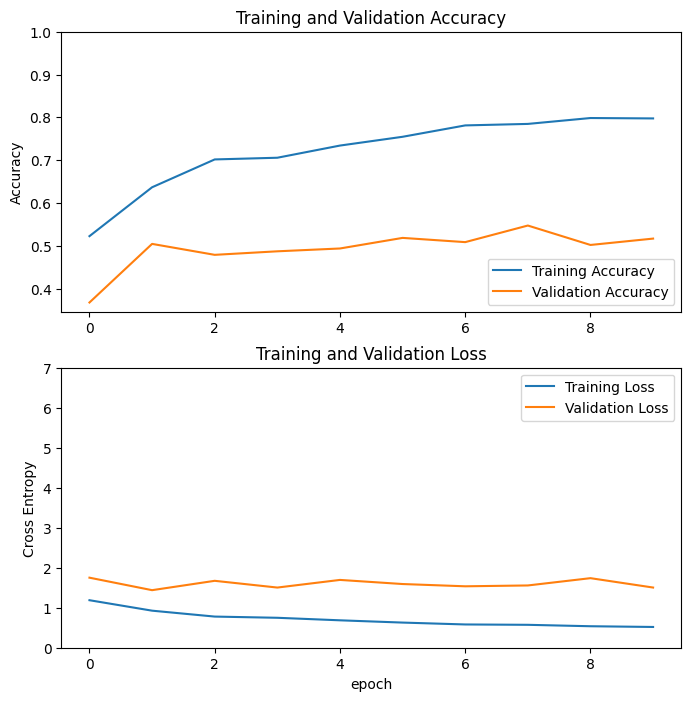

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,7])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning

In [ ]:
#Unfreeze the top layer of the model 
model.trainable = True

In [ ]:
#Examine no. of layers in the base model
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  11


In [ ]:
#Set bottom layers to be untrainable
fine_tune_at = 6  #Fine-tune from this layer onwards

for layer in model.layers[:fine_tune_at]: 
  layer.trainable = False #Freeze all the layers before the 'fine_tune_at' layer

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                  

In [ ]:
#continue training the model

history_fine = model.fit(train_dataset,
                         epochs=50,
                         validation_data=validation_dataset)

Epoch 1/50
135/135 [==============================] - 18s 117ms/step - loss: 0.4230 - accuracy: 0.8409 - val_loss: 1.5633 - val_accuracy: 0.5251
Epoch 2/50
135/135 [==============================] - 17s 120ms/step - loss: 0.3997 - accuracy: 0.8544 - val_loss: 1.6246 - val_accuracy: 0.5169
Epoch 3/50
135/135 [==============================] - 17s 125ms/step - loss: 0.3867 - accuracy: 0.8583 - val_loss: 1.6738 - val_accuracy: 0.5218
Epoch 4/50
135/135 [==============================] - 17s 122ms/step - loss: 0.3749 - accuracy: 0.8581 - val_loss: 1.6523 - val_accuracy: 0.5301
Epoch 5/50
135/135 [==============================] - 16s 116ms/step - loss: 0.3632 - accuracy: 0.8639 - val_loss: 1.6128 - val_accuracy: 0.5342
Epoch 6/50
135/135 [==============================] - 17s 123ms/step - loss: 0.3652 - accuracy: 0.8639 - val_loss: 1.6880 - val_accuracy: 0.5375
Epoch 7/50
135/135 [==============================] - 17s 121ms/step - loss: 0.3597 - accuracy: 0.8670 - val_loss: 1.6449 - val_ac

Observation:
- Overfitting of data observed
- To continue to finetune the model

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

9/9 [==============================] - 2s 96ms/step - loss: 1.7553 - accuracy: 0.5868
Test accuracy : 0.5868055820465088


Predictions:
 [2 2 4 4 1 1 4 4 0 1 2 4 1 4 2 2 0 1 3 0 1 4 0 2 4 2 3 4 2 0 3 1]
Labels:
 [2 2 4 0 3 1 0 4 0 3 4 1 3 4 2 0 3 3 3 0 1 0 4 4 0 2 3 4 2 2 0 1]


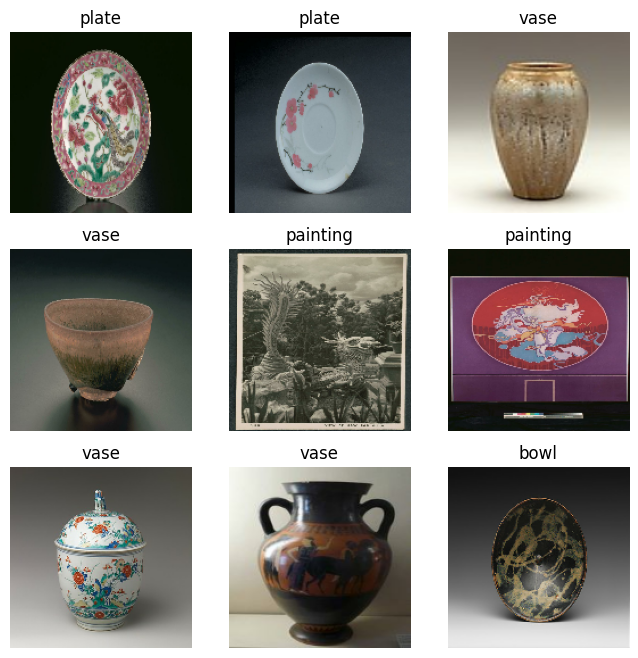

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a softmax since our model returns logits
predictions = tf.math.softmax(predictions)

# Get predicted labels
predictions = tf.math.argmax(predictions, axis = 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(8, 8))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

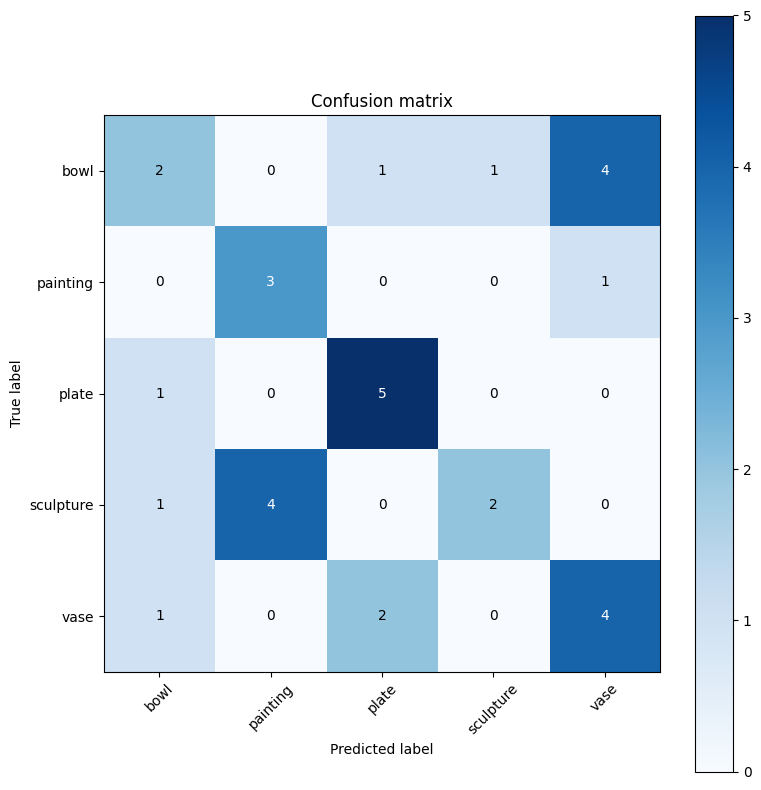

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(label_batch, predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Confusion matrix')
plt.colorbar(im)
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(class_names)
plt.tight_layout()
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Add annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.annotate(str(cm[i, j]), xy=(j, i),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if cm[i, j] > thresh else 'black')
        
plt.show()